## Reading Data

In [70]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import KFold

import sqlalchemy as sqla
import pymysql
from sqlalchemy import create_engine

import csv
import datetime as dt

In [71]:
URI='database-comp30830.c2kwpm1jk01q.us-east-1.rds.amazonaws.com'
PORT='3306'
DB='comp30830_db'
PASSWORD='Simple12'
USER='admin'

In [72]:
engine = create_engine("mysql+mysqldb://{}:{}@{}:{}/{}".format(USER, PASSWORD,
                                                              URI, PORT, DB), echo=True)

In [73]:
bikes=pd.read_sql_table('live_bike_data', engine)  

OperationalError: (MySQLdb._exceptions.OperationalError) (2003, "Can't connect to MySQL server on 'database-comp30830.c2kwpm1jk01q.us-east-1.rds.amazonaws.com' (60)")
(Background on this error at: http://sqlalche.me/e/e3q8)

In [5]:
# Make a new dataframe of this table
bikes.to_csv('allBikes.csv', index=False)

In [6]:
# Read csv file into a dataframe.
bikes = pd.read_csv('allBikes.csv')

In [83]:
weather=pd.read_sql_table('live_weather_data', engine)  

2020-03-31 21:23:58,203 INFO sqlalchemy.engine.base.Engine SHOW FULL TABLES FROM `comp30830_db`
2020-03-31 21:23:58,204 INFO sqlalchemy.engine.base.Engine ()
2020-03-31 21:23:58,318 INFO sqlalchemy.engine.base.Engine SHOW FULL TABLES FROM `comp30830_db`
2020-03-31 21:23:58,319 INFO sqlalchemy.engine.base.Engine ()
2020-03-31 21:23:58,434 INFO sqlalchemy.engine.base.Engine SHOW CREATE TABLE `live_weather_data`
2020-03-31 21:23:58,435 INFO sqlalchemy.engine.base.Engine ()
2020-03-31 21:23:58,671 INFO sqlalchemy.engine.base.Engine SELECT live_weather_data.number, live_weather_data.main, live_weather_data.description, live_weather_data.icon, live_weather_data.temp, live_weather_data.`tempMin`, live_weather_data.`tempMax`, live_weather_data.`tempFeels`, live_weather_data.humidity, live_weather_data.pressure, live_weather_data.`windSpeed`, live_weather_data.`windDeg`, live_weather_data.rain, live_weather_data.sunrise, live_weather_data.sunset, live_weather_data.date, live_weather_data.time, 

In [84]:
# Make a new dataframe of this table
weather.to_csv('allWeather.csv', index=False)

In [9]:
# Read csv file into a dataframe.
weather = pd.read_csv('allWeather.csv')

In [10]:
bikes['datetime'] = pd.to_datetime(bikes['date'] + ' ' + bikes['time'])
weather['datetime'] = pd.to_datetime(weather['date'] + ' ' + weather['time'])

In [11]:
bikes = bikes.sort_values(by='datetime')
weather = weather.sort_values(by='datetime')

## This can be used as a checkpoint, start from here if you want to run again without having to call from the database.

In [12]:
full_df = pd.merge_asof(bikes, weather, left_on="datetime", right_on="datetime",direction="nearest")

In [13]:
full_df.head(3)

,ID,availableBikeStands,availableBikes,date_x,time_x,day_x,status,epoch,datetime,number,...,humidity,pressure,windSpeed,windDeg,rain,sunrise,sunset,date_y,time_y,day_y
0,84,6,24,2020-02-18,19:54:59,Tue,OPEN,NaN,2020-02-18 19:54:59,802,...,72.0,1015.0,5.7,250.0,0.0,07:38:33,17:39:42,2020-02-18,22:00:01,Tue
1,67,21,19,2020-02-18,19:55:27,Tue,OPEN,NaN,2020-02-18 19:55:27,802,...,72.0,1015.0,5.7,250.0,0.0,07:38:33,17:39:42,2020-02-18,22:00:01,Tue
2,8,30,0,2020-02-18,19:55:35,Tue,OPEN,NaN,2020-02-18 19:55:35,802,...,72.0,1015.0,5.7,250.0,0.0,07:38:33,17:39:42,2020-02-18,22:00:01,Tue


In [14]:
# constrict the dataframe to only those times in which the service is available to users.
full_df = full_df.drop(full_df[(full_df.datetime.dt.hour > 0) & (full_df.datetime.dt.hour < 5)].index)

In [15]:
## Create four flags each representing the stage of the day.
morning_start = pd.to_datetime("05:00:00").time()
morning_end = pd.to_datetime("12:00:00").time()
afternoon_start = pd.to_datetime("12:01:00").time()
afternoon_end = pd.to_datetime("16:59:00").time()
evening_start = pd.to_datetime("17:00:00").time()
evening_end = pd.to_datetime("20:00:00").time()
night_start = pd.to_datetime("20:01:00").time()
night_end = pd.to_datetime("23:59:59").time()

In [16]:
full_df['morning'] = np.where((full_df['datetime'].dt.time > morning_start)
                         & (full_df['datetime'].dt.time < morning_end),
                         1, 0)

full_df['afternoon'] = np.where((full_df['datetime'].dt.time > afternoon_start)
                         & (full_df['datetime'].dt.time < afternoon_end),
                         1, 0)

full_df['evening'] = np.where((full_df['datetime'].dt.time > evening_start)
                         & (full_df['datetime'].dt.time < evening_end),
                         1, 0)

full_df['night'] = np.where((full_df['datetime'].dt.time > night_start)
                         & (full_df['datetime'].dt.time < night_end),
                         1, 0)

In [17]:
#replace days with numbers
full_df["day_x"].replace(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], [0,1,2,3,4,5,6], inplace=True)

In [18]:
# create a time of day column, based on the hours of the day.
full_df['tod'] = full_df.datetime.dt.hour

- Observe the usage on a given weekday at a particular station:

In [19]:
weekday_test_df = full_df.loc[(full_df['ID'] == 84) & (full_df['day_x'] == 2)]

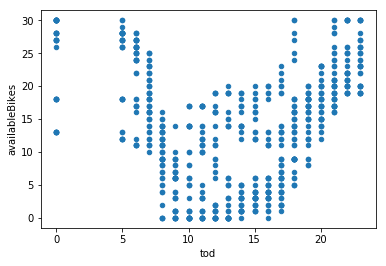

In [20]:
# First, plot the observed data
weekday_test_df.plot(kind='scatter', x='tod', y='availableBikes')

In [21]:
weekday_test_df = full_df.loc[(full_df['ID'] == 84) & (full_df['day_x'] == 4)]

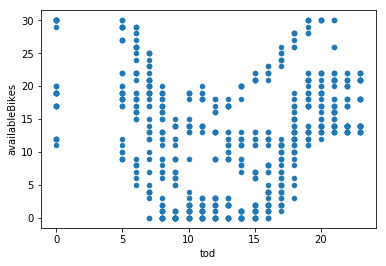

In [22]:
weekday_test_df.plot(kind='scatter', x='tod', y='availableBikes')

- Observe the usage on a given weekend day at the same station:

In [23]:
weekend_test_df = full_df.loc[(full_df['ID'] == 84) & (full_df['day_x'] == 5)]

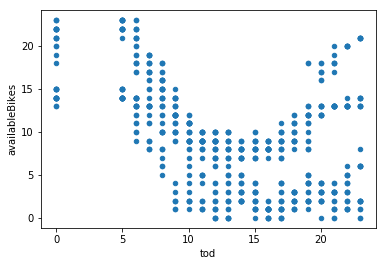

In [24]:
# First, plot the observed data
weekend_test_df.plot(kind='scatter', x='tod', y='availableBikes')

### From each of these plots, we can observe a variance between usage during the week and during the weekend. Weekdays generally see heavier usage during the morning time, while weekends see more usage during the afternoon/evening time. Therefore, two spearate models will be developed- one for Monday to Friday and another for Saturdays and Sundays.

In [25]:
#clouds
full_df["number"].replace([801,802,803,804], 'clouds', inplace=True)

#clear
full_df["number"].replace([800], 'clear', inplace=True)

#Atmosphere
full_df["number"].replace([701,711,721,731,741,751,761,762,771,781], 'Atmosphere', inplace=True)

#snow
full_df["number"].replace([600,601,602,611,612,613,615,616,620,621,622], 'snow', inplace=True)

#rain
full_df["number"].replace([500,501,502,503,504,511,520,521,522,531], 'rainfall', inplace=True)

#drizzle
full_df["number"].replace([300,301,302,310,311,312,313,314,321], 'drizzle', inplace=True)

#thunderstorm
full_df["number"].replace([200,201,202,210,211,212,221,230,231,232], 'thunderstorm', inplace=True)

In [26]:
full_df.head()

,ID,availableBikeStands,availableBikes,date_x,time_x,day_x,status,epoch,datetime,number,...,sunrise,sunset,date_y,time_y,day_y,morning,afternoon,evening,night,tod
0,84,6,24,2020-02-18,19:54:59,1,OPEN,NaN,2020-02-18 19:54:59,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19
1,67,21,19,2020-02-18,19:55:27,1,OPEN,NaN,2020-02-18 19:55:27,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19
2,8,30,0,2020-02-18,19:55:35,1,OPEN,NaN,2020-02-18 19:55:35,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19
3,106,20,20,2020-02-18,19:55:57,1,OPEN,NaN,2020-02-18 19:55:57,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19
4,36,38,0,2020-02-18,19:56:09,1,OPEN,NaN,2020-02-18 19:56:09,clouds,...,07:38:33,17:39:42,2020-02-18,22:00:01,Tue,0,0,1,0,19


In [27]:
full_df.drop(["date_x","time_x","status", "epoch", "main",
         "description","icon", "tempMin", "tempMax", "tempFeels", "humidity",
         "pressure", "windSpeed","windDeg","sunrise", "sunset",
             "date_y","time_y", "day_y"],axis=1,inplace=True)

In [28]:
# add a flag that indicates whether a day is dry (has zero rain)
full_df['dry_day'] = (full_df['rain'] == 0).astype(int)

In [29]:
choice = int(input("Please enter a number to predict for either availableBikes - (0) or availableBikeStands - (1): "))
if choice == 0:
    full_df = full_df.rename(columns={"availableBikes": "target"})
    full_df.drop(["availableBikeStands"], axis=1,inplace=True)    
else:
    full_df = full_df.rename(columns={"availableBikeStands": "target"})
    full_df.drop(["availableBikes"], axis=1,inplace=True)

Please enter a number to predict for either availableBikes - (0) or availableBikeStands - (1): 0


In [30]:
week_df = full_df.loc[(full_df['day_x'] >= 0) & (full_df['day_x'] <= 4)]

In [31]:
weekend_df = full_df.loc[(full_df['day_x'] >= 5) & (full_df['day_x'] <= 6)]

In [32]:
station = int(input("Please enter station ID: "))
week_or_weekend = int(input("Please choose to predict for week - (0) or weekend - (1): "))
# bikes_or_stands = int(input("Please choose to predict either availableBikeStands(0) or availableBikes(1): "))
# Constrain df to a single station on a single day
if week_or_weekend == 0:
    new_df = week_df.loc[(week_df.ID == station)]
else:
    new_df = weekend_df.loc[(weekend_df.ID == station)]

# Constrain df to a single station on a single day
# new_df = full_df.loc[(full_df['ID'] == station) & (full_df['day_x'] == day)]

Please enter station ID: 42
Please choose to predict for week - (0) or weekend - (1): 0


In [33]:
## Dropping all columns not necessary for predictive model.
new_df.drop(["ID", "datetime"], axis=1,inplace=True)

/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [34]:
# Make a new dataframe of this station
new_df.to_csv('comp303830_model_multipleLinearRegression.csv', index=False)

In [35]:
# Read csv file into a dataframe.
df = pd.read_csv('comp303830_model_multipleLinearRegression.csv')

In [36]:
df.head(3)

,target,day_x,number,temp,rain,morning,afternoon,evening,night,tod,dry_day
0,28,1,clouds,2.0,0.0,0,0,0,1,20,1
1,29,1,clouds,2.0,0.0,0,0,0,1,20,1
2,30,1,clouds,2.0,0.0,0,0,0,1,20,1


In [37]:
# Print the average target(availableBikes/availableBikeStands) in our dataset.
# We could use this as a very simple baseline prediction model.
# A better prediction model should at least improve on this baseline model.
round(df.target.mean())

17.0

### Observing the data:
- Trying to find correlations between continuous data and the target feature:

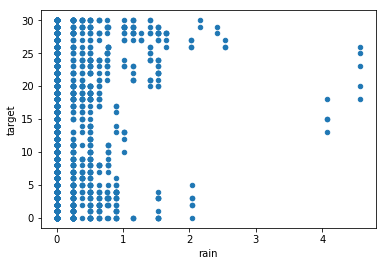

In [38]:
# First, plot the observed data
df.plot(kind='scatter', x='rain', y='target')

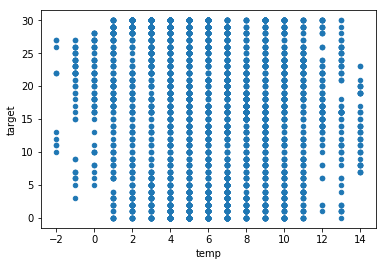

In [39]:
# First, plot the observed data
df.plot(kind='scatter', x='temp', y='target')

- There does not appear to be a clear correlation between the target feature and the continuous data

In [40]:
## Keep this pandas series for later.
## Will be used below.
tod_placeholder = df[['tod']]

# Training with continuous and categorical features

In [41]:
#replace days with numbers
df["day_x"].replace([0,1,2,3,4,5,6], ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], inplace=True)

In [42]:
#We can also do this directly for all categorical features
df = pd.get_dummies(df, drop_first=True)

In [43]:
# Input features must exclude the target feature
column_names = list(df.columns)[1:]

In [44]:
X = df[column_names]
y = df.target

In [45]:
# drop_first = True removes multi-collinearity
add_var = pd.get_dummies(X['tod'], prefix='tod', drop_first=True)
# Add all the columns to the model data
X = X.join(add_var)
# Drop the original column that was expanded
X.drop(columns=['tod'], inplace=True)

In [46]:
X.head()

,temp,rain,morning,afternoon,evening,night,dry_day,day_x_Mon,day_x_Thu,day_x_Tue,...,tod_14,tod_15,tod_16,tod_17,tod_18,tod_19,tod_20,tod_21,tod_22,tod_23
0,2.0,0.0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,2.0,0.0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,2.0,0.0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,2.0,0.0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,2.0,0.0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0


## Train a model based upon multiple linear regression

In [47]:
# Drop any rows with null values
df.dropna(axis=0, how='any', inplace=True)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
df['deg_1_pred'] = model.predict(X)

In [48]:
#This function is used repeatedly to compute all metrics
def printMetrics(testActualVal, predictions):
    #classification evaluation measures
    print('\n==============================================================================')
    print("MAE: ", metrics.mean_absolute_error(testActualVal, predictions))
    #print("MSE: ", metrics.mean_squared_error(testActualVal, predictions))
    print("RMSE: ", metrics.mean_squared_error(testActualVal, predictions)**0.5)
    print("R2: ", metrics.r2_score(testActualVal, predictions))

In [49]:
printMetrics(y, model.predict(X))


MAE:  5.6358302998714525
RMSE:  6.757625668276004
R2:  0.5027166228680544


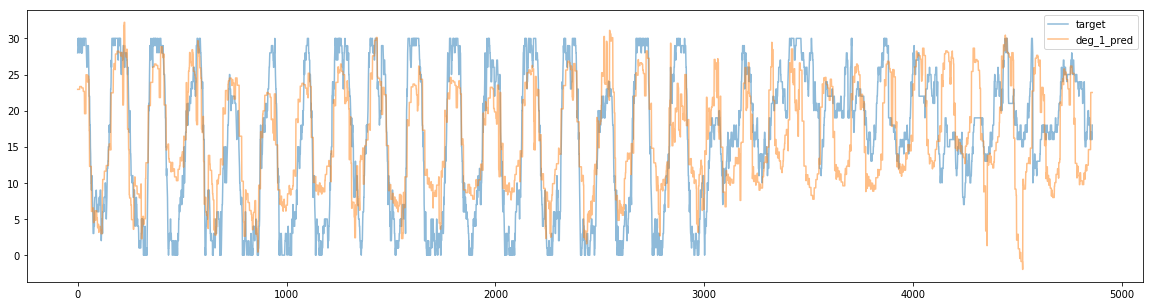

In [50]:
df[['target', 'deg_1_pred']].plot(alpha=0.5, figsize=(20, 5))

<ref: https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html >

## Use k-folds cross-validation (k=3) to assess the performance of our model:

In [51]:
X_column_name = list(X.columns)
X_one_deg = pd.DataFrame(X[X_column_name])
y = pd.DataFrame(df.target)
model = LinearRegression()
scores = []
print("Coefficient of Determination (R2):")
kfold = KFold(n_splits=3, shuffle=True, random_state=42)
for i, (train, test) in enumerate(kfold.split(X_one_deg, y)):
    model.fit(X_one_deg.iloc[train,:], y.iloc[train,:])
    score = model.score(X_one_deg.iloc[test,:], y.iloc[test,:])
    scores.append(score)
    print(scores)

Coefficient of Determination (R2):
[0.559898335705632]
[0.559898335705632, 0.5059023680841612]
[0.559898335705632, 0.5059023680841612, 0.5393441689253216]


<ref: https://becominghuman.ai/linear-regression-in-python-with-pandas-scikit-learn-72574a2ec1a5 >

## Having already observed a nonlinear relationship between bike availability and the time of the day, we will now investigate whether our linear model would more effectively predict our target value if implemented polynomially.

In [52]:
## Using scikit's built-in Polynomial Features
polynomial_features= PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X)

In [53]:
model = LinearRegression()
model.fit(X_poly, y)
y_poly_pred = model.predict(X_poly)
df['deg_2_pred'] = y_poly_pred

rmse = np.sqrt(mean_squared_error(y,y_poly_pred))
r2 = r2_score(y,y_poly_pred)
print("Root Mean Square Error: ", rmse)
print("Coefficient of Determination (R2): ", r2)

Root Mean Square Error:  5.476686977929548
Coefficient of Determination (R2):  0.6733734232127628


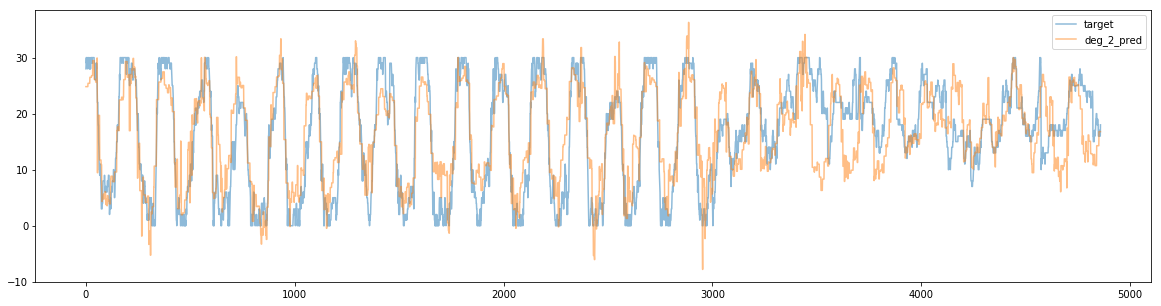

In [54]:
df[['target', 'deg_2_pred']].plot(alpha=0.5, figsize=(20, 5))

## The model trained on polynomial data appears to offer a marginally improved r^2 value in comparison to the single dimensional based model.

# Train/Testing evaluation will be carried out on each model.

## Evaluation with train/test split - single dimensional & polynomial based models.

In [55]:
# Split the data into train and test sets
# Take a third (random) data samples as test data, rest as training data
X_train_one_d, X_test_one_d, y_train_one_d, y_test_one_d = train_test_split(X, y, test_size=0.3)
X_train_polynomial, X_test_polynomial, y_train_polynomial, y_test_polynomial = train_test_split(X_poly, y, test_size=0.3)

In [69]:
X_test_one_d

,temp,rain,morning,afternoon,evening,night,dry_day,day_x_Mon,day_x_Thu,day_x_Tue,...,tod_14,tod_15,tod_16,tod_17,tod_18,tod_19,tod_20,tod_21,tod_22,tod_23
2620,10.0,0.00,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2434,5.0,0.51,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
140,9.0,0.00,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2098,7.0,0.00,0,1,0,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3075,5.0,0.25,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3238,5.0,0.00,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1416,10.0,0.00,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3207,6.0,0.25,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2472,10.0,0.89,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
324,5.0,0.25,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [56]:
# Train on the training sample and test on the test sample.
one_d_multi_linreg = LinearRegression().fit(X_train_one_d, y_train_one_d)
polynomial_multi_linreg = LinearRegression().fit(X_train_polynomial, y_train_polynomial)

In [57]:
# Predicted avaialbleBikes/availableBikeStands on training set
one_d_train_predictions = one_d_multi_linreg.predict(X_train_one_d)
polynomial_train_predictions = polynomial_multi_linreg.predict(X_train_polynomial)
print("Training metrics for single dimensional model:")
printMetrics(y_train_one_d, one_d_train_predictions)
print(" ")
print("Training metrics for polynomial model:")
printMetrics(y_train_polynomial, polynomial_train_predictions)

Training metrics for single dimensional model:

MAE:  5.411420397506911
RMSE:  6.4413883226499715
R2:  0.5523058042767931
 
Training metrics for polynomial model:

MAE:  4.192976873364739
RMSE:  5.405952761627749
R2:  0.6805875296507327


### The training metrics for the polynomial model are marinally better than the single-dimensional model.

In [58]:
# Predicted avaialbleBikes/availableBikeStands on test set
one_d_test_predictions = one_d_multi_linreg.predict(X_test_one_d)
polynomial_test_predictions = polynomial_multi_linreg.predict(X_test_polynomial)

# print("Actual values of one dimensionaltest:\n", y_test_one_d)
# print("Predictions on single dimensional test:", one_d_test_predictions)
print("Testing metrics for single dimensional model:")
printMetrics(y_test_one_d, one_d_test_predictions)
print(" ")
# print("Actual values of polynomial test:\n", y_test_polynomial)
# print("Predictions on polynomial test:", polynomial_test_predictions)
print("Testing metrics for polynomial model:")
printMetrics(y_test_polynomial, polynomial_test_predictions)

Testing metrics for single dimensional model:

MAE:  5.603384933220242
RMSE:  6.596120932081165
R2:  0.5156494553267229
 
Testing metrics for polynomial model:

MAE:  53678285.3771945
RMSE:  1216840894.504965
R2:  -1.5992209445188272e+16


In [65]:
print(type(polynomial_test_predictions))

<class 'numpy.ndarray'>


In [66]:
print(polynomial_test_predictions)

[[23.58608246]
 [18.04595184]
 [ 9.4656601 ]
 ...
 [25.76799774]
 [25.15444183]
 [26.75148773]]


### Here we can observe differences in the results produced by each model when trained on data from the days of the the week as opposed to the days of the weekend:
#### The polynomial model, when introduced to unseen data, performs extremely poorly on the days of the week based data. This is likely due to overfitting. For this reason we will discard the polynomial model for our data based upon the days of the week.
#### However, the polynomial model performs noticeably better than the single dimensional model when trained with data from the weekend days. For this reason we will use the polynomial model for the days of the weekend based model.
## Cross validation of each model will now be performed.

## Evaluation with cross-validation - single dimensional based model.

In [59]:
# sorted(metrics.SCORERS.keys())

In [60]:
one_d_scores = -cross_val_score(LinearRegression(), X, y, scoring='neg_mean_absolute_error', cv=5)
one_d_scores

array([5.35766674, 6.012923  , 6.0099225 , 7.70436444, 7.55119287])

In [61]:
one_d_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
one_d_scores = cross_validate(LinearRegression(), X, y, scoring=one_d_metrics, cv=5)
print("Metrics on cross validated one dimensional based model:")
one_d_scores

Metrics on cross validated one dimensional based model:


/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_absolute_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)

{'fit_time': array([0.00644898, 0.00585294, 0.00554013, 0.00409293, 0.00563622]),
 'score_time': array([0.00419116, 0.00316381, 0.00491476, 0.00270319, 0.0039618 ]),
 'test_neg_mean_absolute_error': array([-5.35766674, -6.012923  , -6.0099225 , -7.70436444, -7.55119287]),
 'train_neg_mean_absolute_error': array([-5.58868497, -5.55658605, -5.51459215, -4.92155683, -4.87514491]),
 'test_neg_mean_squared_error': array([-38.33140421, -47.57593998, -45.90749692, -82.20545244,
        -78.25327203]),
 'train_neg_mean_squared_error': array([-44.29023648, -42.55265338, -42.89671132, -35.25443952,
        -36.17276147]),
 'test_r2': array([ 0.66632846,  0.61152577,  0.63560815, -0.68161719, -2.3579405 ]),
 'train_r2': array([0.48057129, 0.48264804, 0.48249178, 0.64816627, 0.66213276])}

## Evaluation with cross-validation - polynomial based model.

In [62]:
polynomial_scores = -cross_val_score(LinearRegression(), X_poly, y, scoring='neg_mean_absolute_error', cv=5)
polynomial_scores

array([8.19185170e+06, 3.71685422e+07, 2.83297365e+08, 1.32170547e+09,
       7.16056706e+10])

In [63]:
polynomial_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
polynomial_scores = cross_validate(LinearRegression(), X_poly, y, scoring=polynomial_metrics, cv=5)
print("Metrics on cross validated polynomial based model:")
polynomial_scores

Metrics on cross validated polynomial based model:


/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_absolute_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_neg_mean_squared_error'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/anaconda3/envs/comp30830/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_r2'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)

{'fit_time': array([0.09091997, 0.11242414, 0.10393786, 0.10565305, 0.10174274]),
 'score_time': array([0.00321984, 0.00306392, 0.00398421, 0.00476313, 0.00299215]),
 'test_neg_mean_absolute_error': array([-8.19185170e+06, -3.71685422e+07, -2.83297365e+08, -1.32170547e+09,
        -7.16056706e+10]),
 'train_neg_mean_absolute_error': array([-4.15059672, -4.06784126, -4.08347442, -3.61712333, -3.95923996]),
 'test_neg_mean_squared_error': array([-3.86234648e+15, -8.54684248e+17, -2.41338269e+18, -8.11773569e+19,
        -4.57050190e+22]),
 'train_neg_mean_squared_error': array([-29.10997802, -27.3651492 , -27.99181369, -21.82060276,
        -26.97192293]),
 'test_r2': array([-3.36213898e+13, -6.97879653e+15, -1.91562828e+16, -1.66058618e+18,
        -1.96125645e+21]),
 'train_r2': array([0.6586029 , 0.66729657, 0.66230526, 0.78223384, 0.74807206])}

In [64]:
sorted(scores.keys())

AttributeError: 'list' object has no attribute 'keys'